# Convolutional Neural Network (CNN) : Reconnaissance d'avions

Dans ce Notebook, nous utilisons Keras pour implémenter un réseau de neurone convolutif (CNN) sur un jeu de données composé de nombreuses images de différentes tailles provenant de 5 classes différentes.
Les données ont été récupérées sur kaggle, sur différentes sources, et nous les avons compilées entre-elles.
Nous nous concentrons sur la reconnaissance de forme afin de pouvoir détecter des avions.

In [5]:
import numpy as np
import os
from PIL import Image, ImageFilter

categories=["avion","ferry","chat","rose","voitures"]

new_im_size = 128
channels = 3



train_data_dir = "data_seminaire"

# 1. Préparation du Dataset
La première chose à faire lorsque l'on traite un nouvel ensemble de données est d'effectuer des opérations de prétraitement. Le prétraitement des données fait généralement référence aux étapes appliquées pour rendre les données plus adaptées à l'apprentissage. Dans cette section, nous allons traiter les points suivants :
* 1.1 Chargement des données
* 1.2 Normalization
* 1.3 Standardization
* 1.4 Split des données et one hot encoding


## 1.1 Chargement des données
Dans cette section, nous chargeons le jeu de données généré dans la section précédente.

In [6]:
# Chargement du dataset
def load_dataset(data_dir_path):
	X = []
	Y = []
	for i in categories :


		import glob
		only_jpg = glob.glob(data_dir_path + "/" + i + "/*.jpg")				# Récupération des images jpg
		only_images = only_jpg											# Merge des images
		for file_name in only_images:												
			image = Image.open(file_name).convert('RGB')
			image = image.resize((new_im_size, new_im_size))						# Resize des images
			X.append(np.array(image, dtype=np.float32))
			Y.append(i)
	return X, Y

In [7]:
train_X, train_Y = load_dataset(train_data_dir)											# training set

In [8]:
#test set
from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(train_X, train_Y, test_size=0.1, random_state=13)

Splitting training set to create test set..


## 1.2 Standardization

Une pratique courante dans le prétraitement des données est la standardization.
L'idée de la standardization est de calculer la moyenne et l'écart-type de votre ensemble de données afin de soustraire de chaque point $x$, sa moyenne $\mu$ de l'ensemble de données, puis de diviser par l'écart-type $\sigma$ .
Il s'agit d'appliquer l'opération suivante :


<img src="https://drive.google.com/uc?id=1rpuybw_fmI8XK38JQhWWxX2TOExBAV2V" width="150px"><br>
L’objectif est d'obtenir une distribution avec une moyenne égale à 0 et un écart-type égal à 1.
En appliquant la normalisation à nos données, nous rendons les caractéristiques plus similaires les unes aux autres, ce qui facilite généralement le processus d'apprentissage.
Pour mieux comprendre cela, nous pouvons montrer un exemple de ce qui se passe après l'application d'un processus de normalisation à un ensemble de données :

<img src="https://drive.google.com/uc?id=1wtqTW4hz8n8k7b7q0mUSzCc9X0npNUY2" width="500px" align="left"><br>

In [9]:
# Standardisation des données
def standardize_dataset(X):
	image_means = []
	image_stds = []

	for image in X:
		image_means.append(np.mean(image))											# Calcul de la moyenne des images
		image_stds.append(np.std(image))											# Calcul de leur écart type

	dataset_mean = np.mean(image_means)												# Calcul de la moyenne du dataset
	dataset_std = np.mean(image_stds)												# Calcul de l'écart type du dataset
	return dataset_mean, dataset_std					

In [10]:
dataset_mean, dataset_std = standardize_dataset(train_X)
train_X = (train_X-dataset_mean)/dataset_std												# Standardization du training set
test_X = (test_X-dataset_mean)/dataset_std												# Standardization du test set

## 1.3 Normalization
Une autre pratique courante dans la formation d'un réseau neuronal consiste à normaliser les images en divisant la valeur de chaque pixel par la valeur maximale possible, c'est-à-dire 255.
L'objectif est d'obtenir une moyenne proche de 0.
La normalisation des données accélère généralement l'apprentissage et conduit à une convergence plus rapide.

In [11]:
# Normalizing the data
train_X = np.asarray(train_X, dtype=np.float32) / 255										# Normalization du training set
test_X = np.asarray(test_X, dtype=np.float32) / 255											# Normalization du test set

## 1.4 Split des données et one hot encoding
Il ne nous reste plus qu'à diviser notre ensemble d'apprentissage en deux pour obtenir l'ensemble de validation, ainsi que one-hot encoder nos labels.

In [12]:
# Creating the validation set
from sklearn.model_selection import train_test_split
train_X, valid_X, train_Y, valid_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=13)

In [13]:
#on catégorise les variables labels en integers pour que le one hot d'après marche
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_Y = label_encoder.fit_transform(train_Y)
valid_Y = label_encoder.fit_transform(valid_Y)
test_Y = label_encoder.fit_transform(test_Y)

In [14]:
# Converting labels to one-hot representation
from keras.utils.np_utils import to_categorical
train_Y_one_hot = to_categorical(train_Y)						# Conversion des train, test, et valid en one hot encoding
valid_Y_one_hot = to_categorical(valid_Y)
test_Y_one_hot = to_categorical(test_Y)

# 2. Entraînement du modèle
Maintenant que nous avons correctement prétraité nos données, nous allons créer un modèle convolutif dans Keras. Comme précisé dans le rapport, un modèle convolutif est composé de deux parties successives :
* Une partie convolutive
* Une partie entièrement connectée, "fully connected"

<img src="https://drive.google.com/uc?id=1duP8u9bs6ELNu4degUuYP4-YS1mBYn2O" width="600px"><br>

Habituellement, la partie convolutive est constituée de plusieurs couches composées de
* couche convolutionnelle : effectue une convolution spatiale sur les images
* couche de pooling : utilisée pour réduire la dimension spatiale de sortie de $n$ à 1 en faisant la moyenne des $n$ valeurs différentes ou en considérant le maximum entre elles
* couche dropout : appliquée à une couche, consiste à "abandonner" de manière aléatoire (c'est-à-dire à mettre à zéro) un certain nombre de caractéristiques de sortie de la couche pendant l'apprentissage.

La partie convolutive produit sa sortie et la partie entièrement connectée relie les informations reçues afin de résoudre le problème de classification.

In [15]:
# Creation du modèle
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from sklearn.metrics import accuracy_score

# Network parameters
batch_size = 16													# Réglage du batch size
epochs = 10														# du nombre d'epoch
num_classes = len(categories)									# du nombre de classes

scratch_model = Sequential()	

# Création du réseau de neurone avec Keras

conv_layer1 = Conv2D(5,3,activation='relu', input_shape=train_X.shape[1:])
scratch_model.add(conv_layer1)
pool_layer2=MaxPooling2D(pool_size=(2, 2))
scratch_model.add(Dropout(0.2))
scratch_model.add(pool_layer2)
conv_layer3 = Conv2D(4,3,activation='relu')
scratch_model.add(conv_layer3)
pool_layer4=MaxPooling2D(pool_size=(2, 2))
scratch_model.add(Dropout(0.2))
scratch_model.add(pool_layer4)
scratch_model.add(Flatten())
scratch_model.add(Dense(num_classes, activation='sigmoid'))





# Compilation du modèle avec l'Adam optimizer
scratch_model.compile(loss=keras.losses.categorical_crossentropy, optimizer="Adam",metrics=['accuracy'])

# Visualisation du mmodèle avec summary
scratch_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 5)       140       
_________________________________________________________________
dropout (Dropout)            (None, 126, 126, 5)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 5)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 4)         184       
_________________________________________________________________
dropout_1 (Dropout)          (None, 61, 61, 4)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 4)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3600)              0

In [16]:
# Entrainement du modèle
scratch_model_history = scratch_model.fit(train_X, train_Y_one_hot, batch_size=batch_size, shuffle=True, epochs=epochs, validation_data=(valid_X, valid_Y_one_hot))

Epoch 1/10
112/112 [==============================] - 18s 45ms/step - loss: 1.4083 - accuracy: 0.4036 - val_loss: 1.2419 - val_accuracy: 0.4719
Epoch 2/10
112/112 [==============================] - 5s 42ms/step - loss: 1.0256 - accuracy: 0.6058 - val_loss: 0.9514 - val_accuracy: 0.7034
Epoch 3/10
112/112 [==============================] - 5s 42ms/step - loss: 0.8825 - accuracy: 0.6918 - val_loss: 0.8716 - val_accuracy: 0.6966
Epoch 4/10
112/112 [==============================] - 5s 43ms/step - loss: 0.7708 - accuracy: 0.7348 - val_loss: 0.8280 - val_accuracy: 0.7124
Epoch 5/10
112/112 [==============================] - 5s 42ms/step - loss: 0.7069 - accuracy: 0.7462 - val_loss: 0.7576 - val_accuracy: 0.7685
Epoch 6/10
112/112 [==============================] - 5s 44ms/step - loss: 0.6220 - accuracy: 0.7733 - val_loss: 0.7656 - val_accuracy: 0.7596
Epoch 7/10
112/112 [==============================] - 5s 43ms/step - loss: 0.6481 - accuracy: 0.7851 - val_loss: 0.7465 - val_accuracy: 0.746

In [17]:
# Résultats
scratch_model_train_acc = scratch_model_history.history['accuracy']
scratch_model_valid_acc = scratch_model_history.history['val_accuracy']
scratch_model_train_loss = scratch_model_history.history['loss']
scratch_model_valid_loss = scratch_model_history.history['val_loss']

print("Test accuracy: ", accuracy_score(np.argmax(scratch_model.predict(test_X), axis=-1), test_Y))			# Testing the model

Test accuracy:  0.8185483870967742


Les résultats obtenus sont très satisfaisants. Cela montre à quel point les architectures CNN sont puissantes en reconnaissance d’images. Ce score est également dû à la facilité de notre problème : les images sont facilement différenciables. Comme évoqué précédemment, lorsque nous essayons de différencier les avions entre-eux nous n’obtenions pas du tout ce genre de résultats.

Comme prévu, lorsque nous augmentons la batch size, le temps d’entraînement du modèle est plus rapide, parce que nous faisons "moins d'étapes" de calcul. Néanmoins, ce procédé a un coût au niveau de la précision du modèle (nous avons besoin de plus de temps pour l’entraîner). Cela est dû au fait que nous devons continuer à entraîner le modèle, il est alors nécessaire d’augmenter le nombre d’epochs pour obtenir de bonnes performances. Le modèle avec une batch size plus grande converge vers la même performance (avec un nombre approprié d‘epoch). En fait, avec une petite batch size, le modèle apprend de maière plus rapide sans nécessiter plus d’epoch.

# 3. Utilisation d'un modèle pré-entraîné

Une alternative courante à la formation d'un modèle à partir de zéro consiste à utiliser un modèle pré-entraîné.
L'idée est de remplacer la partie convolutive par une partie convolutive hautement optimisée, conçue et entraînée précédemment par quelqu'un d'autre.
Habituellement, les modèles que nous pouvons utiliser via keras.applications ont été entraînés sur le jeu de données image net.
Ici, nous utilisons le modèle Xception Net. Son architecture est présentée ci-dessous :

<img src="https://drive.google.com/uc?id=1eKivBCSKnWKyBxmGe5s64oOyhzhuCaqU" width="600px"><br>

Un modèle pré-entraîné peut être un outil très utile. En fait, il s'agit d'un modèle qui a été entraîné sur un très grand jeu de données, avec des ressources très puissantes et qui a de très bonnes performances. Il est composé d'une première partie "convolutionnelle", très efficace pour détecter les motifs de base, et d'une deuxième partie, qui classifie l'objet. Cette deuxième partie est spécifique au problème traité, nous nous intéresserons donc qu'à la première.

In [20]:
# Création du modèle basé sur le modèle pré-entraîné Xception
from tensorflow.keras import applications
Xception_model = applications.Xception(weights = "imagenet", include_top=False, input_shape = (new_im_size, new_im_size, channels))

# Features
train_X_feature = Xception_model.predict(train_X)					# Producing the train feature
valid_X_feature = Xception_model.predict(valid_X)					# Producing the test feature


from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

# Création d'un modèle simple qui classifiera les features extraites de l'Xception
pretrained_model = models.Sequential()
pretrained_model.add(layers.Flatten())
pretrained_model.add(layers.Dense(64, activation='relu'))
pretrained_model.add(layers.Dropout(0.3))
pretrained_model.add(layers.Dense(num_classes, activation='softmax'))
pretrained_model.compile(optimizer=optimizers.RMSprop(lr=2e-4),loss='categorical_crossentropy',metrics=['acc'])

/Users/pierrepersonnat/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [21]:
# Summary du modèle
pretrained_model.build(input_shape=train_X_feature.shape)
pretrained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (1780, 32768)             0         
_________________________________________________________________
dense (Dense)                (1780, 64)                2097216   
_________________________________________________________________
dropout (Dropout)            (1780, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (1780, 5)                 325       
Total params: 2,097,541
Trainable params: 2,097,541
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Entrainement
pretrained_model_history = pretrained_model.fit(train_X_feature, train_Y_one_hot, epochs=epochs, batch_size=batch_size, validation_data=(valid_X_feature, valid_Y_one_hot))

Epoch 1/10
112/112 [==============================] - 2s 12ms/step - loss: 1.0709 - acc: 0.6326 - val_loss: 0.9218 - val_acc: 0.6180
Epoch 2/10
112/112 [==============================] - 1s 11ms/step - loss: 0.8173 - acc: 0.7213 - val_loss: 0.7796 - val_acc: 0.6787
Epoch 3/10
112/112 [==============================] - 1s 11ms/step - loss: 0.6949 - acc: 0.7624 - val_loss: 0.6922 - val_acc: 0.7730
Epoch 4/10
112/112 [==============================] - 1s 11ms/step - loss: 0.6206 - acc: 0.7871 - val_loss: 0.6465 - val_acc: 0.7888
Epoch 5/10
112/112 [==============================] - 1s 11ms/step - loss: 0.5772 - acc: 0.7966 - val_loss: 0.6684 - val_acc: 0.7393
Epoch 6/10
112/112 [==============================] - 1s 11ms/step - loss: 0.5390 - acc: 0.8163 - val_loss: 0.6150 - val_acc: 0.7775
Epoch 7/10
112/112 [==============================] - 1s 11ms/step - loss: 0.5163 - acc: 0.8275 - val_loss: 0.5903 - val_acc: 0.7910
Epoch 8/10
112/112 [==============================] - 1s 11ms/step - 

In [23]:
# Résultats
pretrained_model_train_acc = pretrained_model_history.history['acc']
pretrained_model_valid_acc = pretrained_model_history.history['val_acc']
pretrained_model_train_loss = pretrained_model_history.history['loss']
pretrained_model_valid_loss = pretrained_model_history.history['val_loss']

test_X_feature = Xception_model.predict(test_X)						# Producing the test feature
print("Test accuracy: ", accuracy_score(np.argmax(pretrained_model.predict(test_X_feature), axis=-1), test_Y))			# Testing the model

Test accuracy:  0.8266129032258065


# 4. Comparaison des modèles

Maintenant que nous avons entraîné les modèles "from scratch" et "pré-entraînés", nous allons comparer les résultats obtenus au cours de l'entraînement. Nous allons considérer la précision et la perte.

Text(0, 0.5, 'loss')

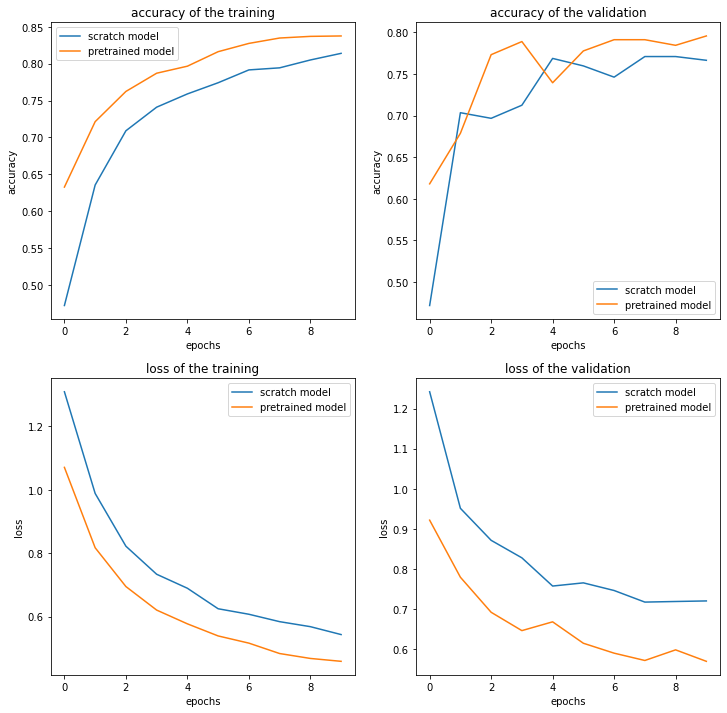

In [24]:
# Plot pour comparer les deux modèles
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))





plt.subplot(2,2,1)

x=range(0,epochs)
plt.plot(x,scratch_model_train_acc,label="scratch model")
plt.plot(x,pretrained_model_train_acc,label="pretrained model")
plt.title("accuracy of the training")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(2,2,2)

x=range(0,epochs)
plt.plot(x,scratch_model_valid_acc,label="scratch model")
plt.plot(x,pretrained_model_valid_acc,label="pretrained model")
plt.title("accuracy of the validation")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy")


plt.subplot(2,2,3)

x=range(0,epochs)
plt.plot(x,scratch_model_train_loss,label="scratch model")
plt.plot(x,pretrained_model_train_loss,label="pretrained model")
plt.title("loss of the training")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.subplot(2,2,4)

x=range(0,epochs)
plt.plot(x,scratch_model_valid_loss,label="scratch model")
plt.plot(x,pretrained_model_valid_loss,label="pretrained model")
plt.title("loss of the validation")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")